# Pre-processing and analysis of feature barcode single-cell RNA-seq data with KITE.

In this notebook, we will perform pre-processing and analysis of [10x Genomics pbmc_1k_protein_v3](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_protein_v3) feature barcoding dataset using the **Kallisto Indexing and Tag Extraction (KITE)** workflow, implemented with a wrapper called kb. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

In Feature Barcoding assays, cellular data are recorded as short DNA sequences using procedures adapted from single-cell RNA-seq. The **KITE** workflow generates a "Mismatch Map" containing the sequences of all Feature Barcodes used in the experiment as well as all of their single-base mismatches. The Mismatch Map is used to produce transcipt-to-gene (.t2g) and fasta (.fa) files to be used as inputs for kallisto. An index is made with kallisto index, then kallisto | bustools effectively searches the sequencing data for the sequences in the Mismatch Map.

## Pre-processing

### Download the data

**Note:** We use the `-O` option for wget to rename the files to easily identify them.

In [ ]:
!sudo apt install wget

In [ ]:
%%time
!wget -q https://caltech.box.com/shared/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt -O checksums.txt
!wget -q https://caltech.box.com/shared/static/mp2vr3p6dztdyatuag8ir3cektmrztg8.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/f3payi1za7mn0jfai7vm10sy3yqwgpqh.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/e112bbczh9o1rl6gfin36bqp0ga7uvdy.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/3ve2axc8dr8v5nnrhmynrdgpqj6xg42k.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz


Then, we verify the integrity of the files we downloaded to make sure they were not corrupted during the download.

In [ ]:
!md5sum -c checksums.txt --ignore-missing

In [ ]:
!python3 --version

### Install `kb`

Install `kb` for running the `kallisto`|`bustools` workflow.

In [ ]:
!pip install --quiet git+https://github.com/pachterlab/kb_python@devel

### Build the feature barcode mismatch index

kb is able to generate a FASTA file containing all hamming distance < 2 variants of the feature barcodes and create a kallisto index of these sequences. But it in order to do so, we first need to prepare a TSV containing feature barcode sequences in the first column and the feature barcode names in the second.

First, we download the feature reference file provided by 10x Genomics.

In [ ]:
!wget -q http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv

Let's load it in as a Pandas DataFrame.

In [ ]:
import pandas as pd

df = pd.read_csv('pbmc_1k_protein_v3_feature_ref.csv')
df

We'll convert this dataframe into a TSV format that kb requires.

In [ ]:
df[['sequence', 'id']].to_csv('features.tsv', index=None, header=None, sep='\t')
!cat features.tsv

Finally, we use kb to generate the mismatch kallisto index.

In [ ]:
!kb ref -i mismatch.idx -f1 mismatch.fa -g t2g.txt --workflow kite features.tsv

### Generate a feature count matrix in H5AD format

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice we are providing the index and transcript-to-gene mapping we generated in the previous step to the `-i` and `-g` arguments respectively. Also, these reads were generated with the 10x Genomics Chromium Single Cell v3 Chemistry, hence the `-x 10xv3` argument. To view other supported technologies, run `kb --list`.

Note: If you would like a Loom file instead, replace the `--h5ad` flag with `--loom`. If you want to use the raw matrix output by kb instead of their H5AD or Loom converted files, omit these flags.

In [ ]:
%%time
!kb count --h5ad -i mismatch.idx -g t2g.txt -x 10xv3 --workflow kite -t 2 \
pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by kb count into Python and cluster the cells with Leiden.

### Install packages

Google Colab does not come with Scanpy, python-igraph, or louvain (but comes with `matplotlib`, `numpy`, `pandas`, and `scipy`).

In [ ]:
!pip install cmake

In [ ]:
!pip install leidenalg scanpy MulticoreTSNE

In [ ]:
!pip install leidenalg scanpy

In [ ]:
 !pip install MulticoreTSNE

### Import packages

In [51]:
import anndata
import numpy as np
import scanpy as sc

In [52]:
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')

In [53]:
adata

AnnData object with n_obs × n_vars = 108482 × 17

In [54]:
adata.obs.head()

""
barcode
AAACCCAAGAAACCCA
AAACCCAAGACGAGGA
AAACCCAAGAGTGTGT
AAACCCAAGAGTGTTG
AAACCCAAGATAGCAC


In [55]:
adata.var

""
feature_id
CD3
CD4
CD8a
CD14
CD15
CD16
CD56
CD19
CD25


### Plot counts

In [56]:
sc.pp.filter_cells(adata, min_counts=0)

In [57]:
sc.pp.filter_genes(adata, min_counts=0)

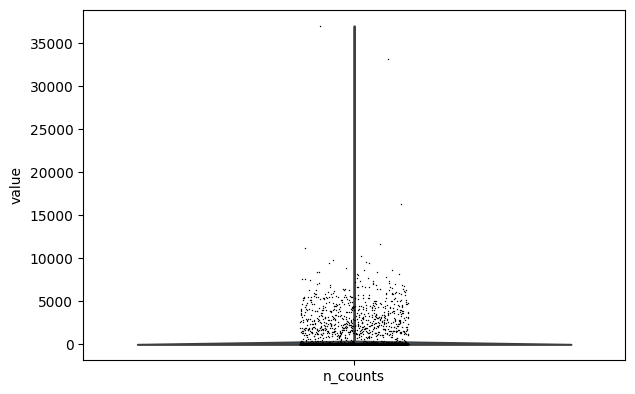

In [58]:
sc.pl.violin(adata, keys='n_counts')

In [59]:
adata.obs['n_countslog'] = np.log1p(adata.obs['n_counts'])

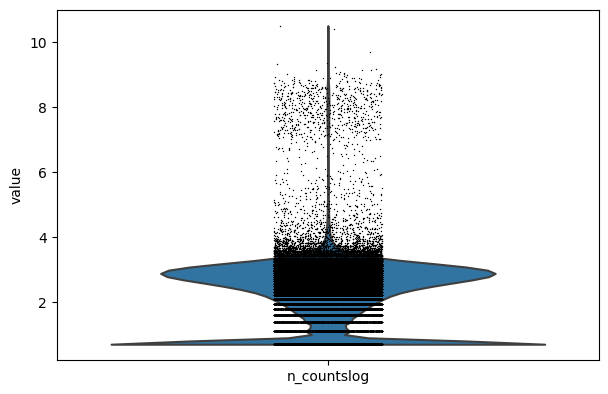

In [60]:
sc.pl.violin(adata, keys='n_countslog')

In [61]:
adata.obs.index

Index(['AAACCCAAGAAACCCA', 'AAACCCAAGACGAGGA', 'AAACCCAAGAGTGTGT',
       'AAACCCAAGAGTGTTG', 'AAACCCAAGATAGCAC', 'AAACCCAAGATGAGTC',
       'AAACCCAAGATGGTAC', 'AAACCCAAGATTCGTT', 'AAACCCAAGCACATAG',
       'AAACCCAAGCATTCAT',
       ...
       'TTTGTTGTCGCGTTGA', 'TTTGTTGTCGTTGACG', 'TTTGTTGTCTAACCGG',
       'TTTGTTGTCTATGTAG', 'TTTGTTGTCTCAACAA', 'TTTGTTGTCTCACTCA',
       'TTTGTTGTCTCTTCGA', 'TTTGTTGTCTCTTGGT', 'TTTGTTGTCTGCACTT',
       'TTTGTTGTCTGCGACA'],
      dtype='object', name='barcode', length=108482)

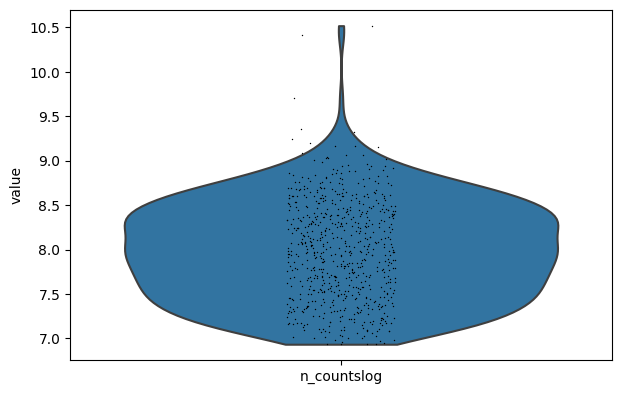

AnnData object with n_obs × n_vars = 686 × 17
    obs: 'n_counts', 'n_countslog'
    var: 'n_counts'

In [62]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pl.violin(adata, keys='n_countslog', title="kallisto UMI counts")
adata

Here are violin plots for each Feature Barcode (antibody-oligo conjugates, x-axis) across all cells.

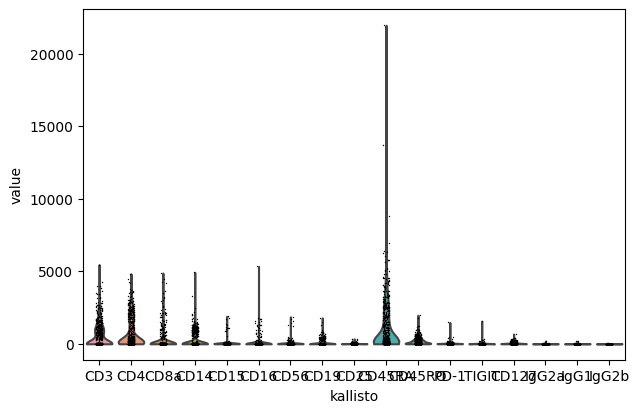

In [63]:
sc.pl.violin(adata, keys=list(adata.var.index)[-17:], xlabel='kallisto')

### Cluster with Leiden

In [64]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

In [65]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [66]:
sc.tl.leiden(adata, resolution=0.05)

/opt/padogrid/products/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


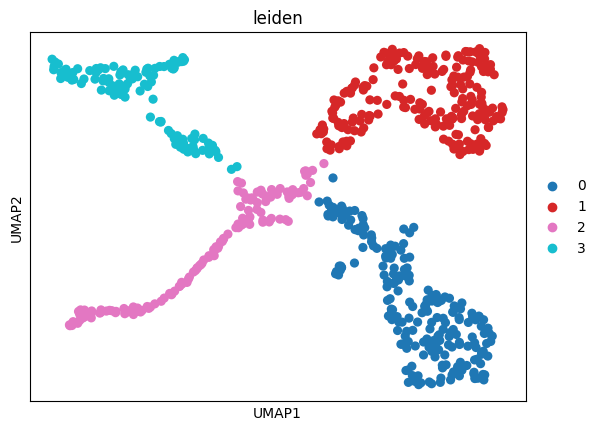

In [67]:
sc.pl.umap(adata, color='leiden', palette='tab10')

### Embedding and Antibody Quantification

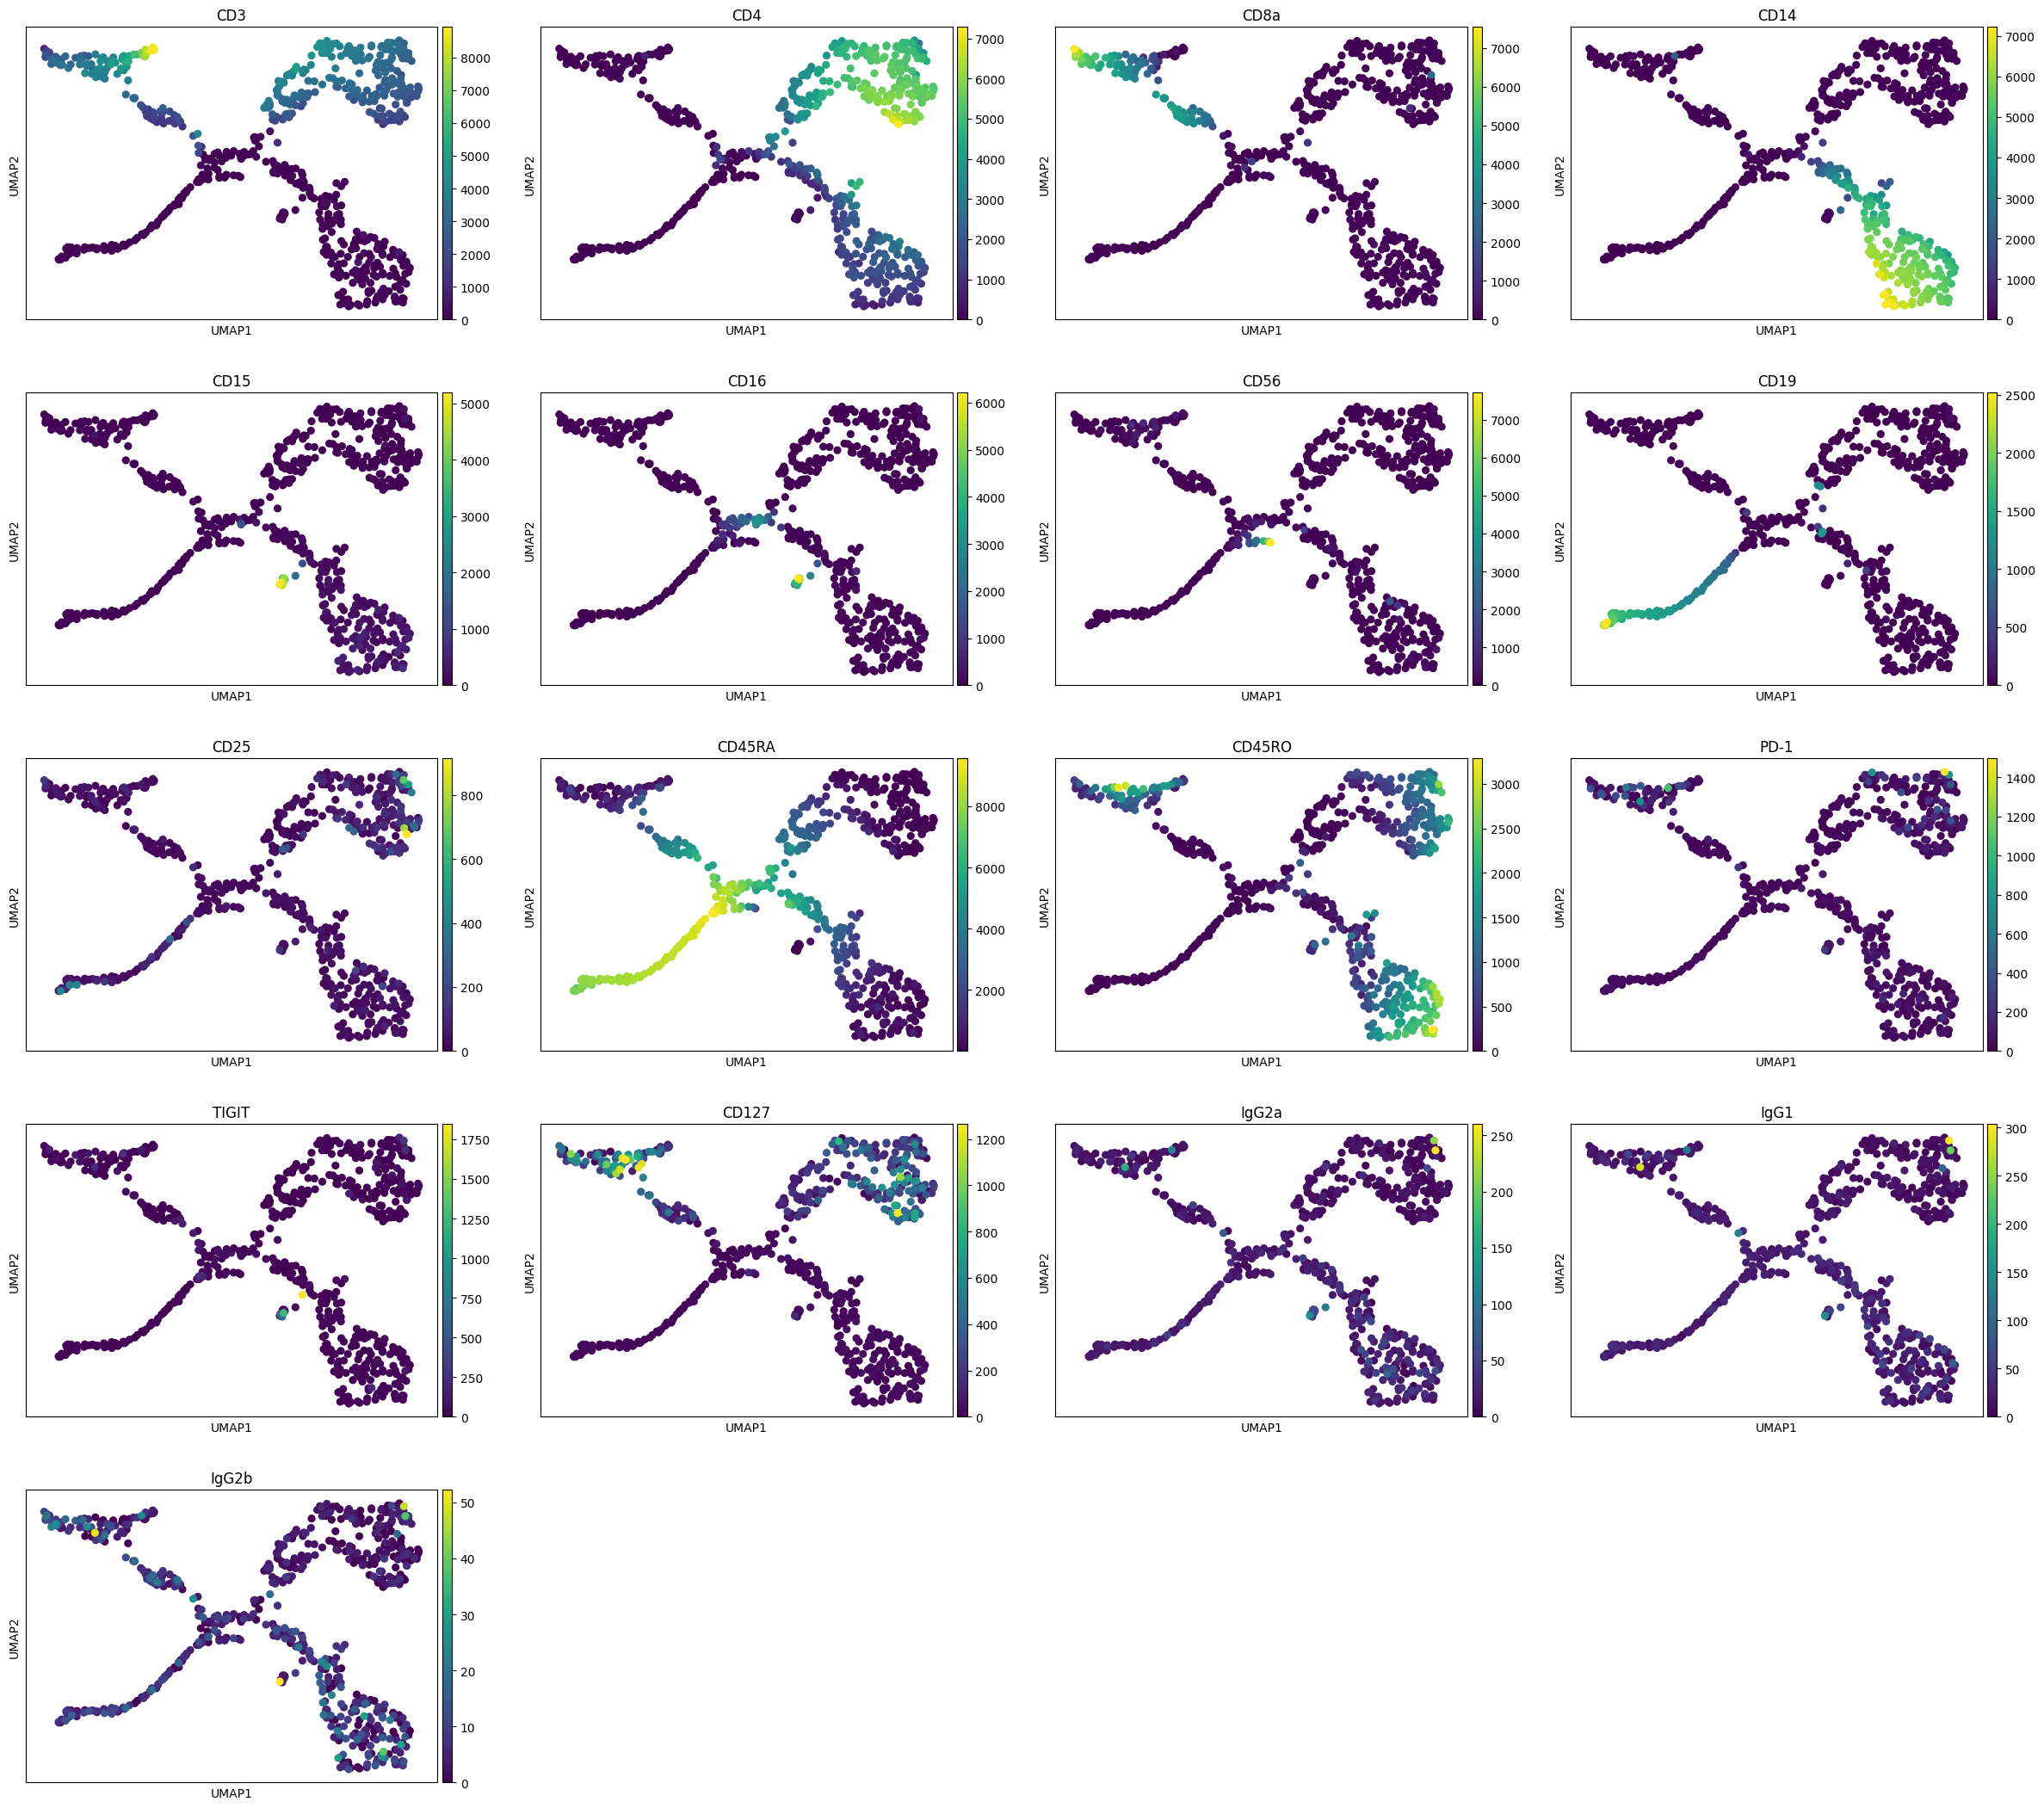

In [69]:
sc.pl.umap(adata, color=adata.var.index)

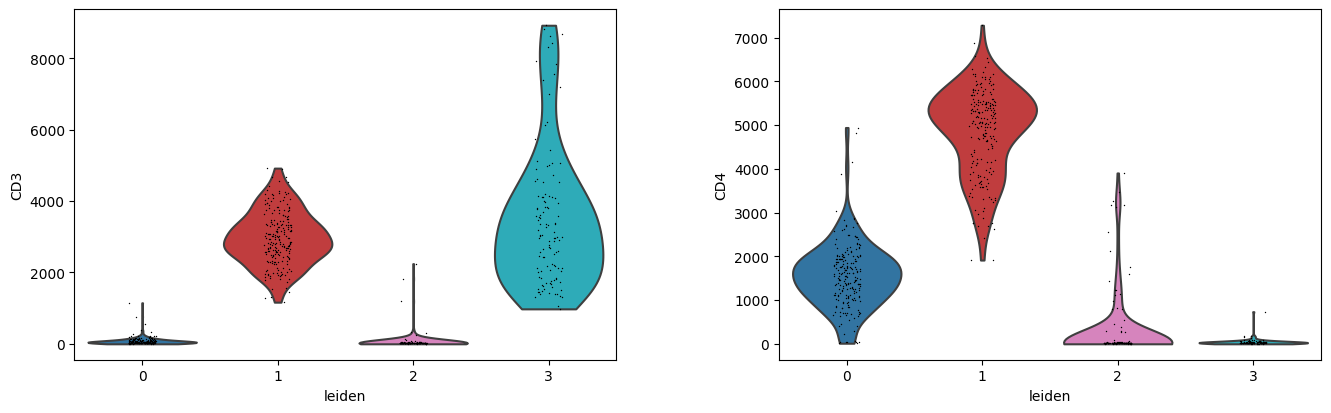

In [70]:
sc.pl.violin(adata, keys=list(adata.var.index[:2]), groupby='leiden')